# ResNet Experiments

Here we train the ResNet-18 network and a ResNet-18 network with Octave Convolution layers on the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [47]:
import os
import time
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets

In [15]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

Information about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [16]:
data_dir = 'tiny-imagenet-200/'

In [71]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [72]:
# Create mini datasets for quick debugging

num_mini_samples = 100
for x in ['train', 'val']:
    mini_indices = random.sample(range(len(image_datasets[x])), k=num_mini_samples)
    mini_sampler = torch.utils.data.SubsetRandomSampler(mini_indices)
    dataloaders[x + '_mini'] = torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                            shuffle=False, num_workers=4,
                                                            sampler=mini_sampler)
    dataset_sizes[x + '_mini'] = dataloaders[x + '_mini'].batch_size * len(dataloaders[x + '_mini'])

print("Number of examples in train_mini: {}".format(dataset_sizes['train_mini']))
print("Number of examples in train_val: {}".format(dataset_sizes['val_mini']))

Number of examples in train_mini: 100
Number of examples in train_val: 100


In [74]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 224, 224])
Image class: 0


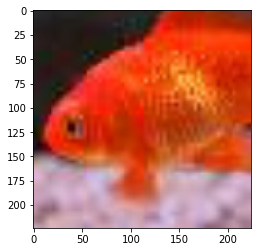

In [75]:
sample = image_datasets['train'][100]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

## Vanilla ResNet-18 Model

Here we load the ResNet-18 model from torchvision.models

In [76]:
resnet18 = torchvision.models.resnet18(num_classes=200, pretrained=False)
best_resnet_path = './best_Res18.pth'

## Training ResNet-18

In [99]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import copy

def train_model(model, criterion, optimizer, save_path, scheduler=None, num_epochs=25, train_name='train', val_name='val'):
    """
    
    
    train_name (string): can be set to 'train_mini' to train on mini set.
    val_name (string): can be set to 'val_mini' to validate on mini set
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_name, val_name]:
            if phase == train_name:
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_name):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_name:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model, save weights to file
            if phase == val_name and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), save_path)
                print("Saved best model to {}".format(save_path))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [100]:
# Taken from https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_optim.html
loss_fn = torch.nn.functional.cross_entropy
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

In [101]:
# Train on a mini dataset to debug
mini_model = train_model(resnet18, loss_fn, optimizer, 'mini_resnet18.pth', num_epochs=1, train_name='train_mini', val_name='val_mini')

Epoch 0/0
----------
train_mini Loss: 5.3876 Acc: 0.0200
val_mini Loss: 5.0128 Acc: 0.0000

Training complete in 0m 44s
Best val Acc: 0.000000


## Loading Trained Model

In [95]:
resnet18.load_state_dict(torch.load(best_resnet_path))

In [96]:
def evaluate_model(model, criterion, val_name='val'):
    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for i, (inputs, labels) in enumerate(dataloaders[val_name]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[val_name]
    epoch_acc = running_corrects.double() / dataset_sizes[val_name]

    print('Loss on {}: {:.4f} Acc: {:.4f}'.format(
        val_name, epoch_loss, epoch_acc))

In [97]:
evaluate_model(resnet18, loss_fn, val_name='val_mini')

Loss on val_mini: 5.4778 Acc: 0.0000


## Training the Big Model

In [98]:
# Train the actual big model
resnet18 = torchvision.models.resnet18(num_classes=200, pretrained=False)
loss_fn = torch.nn.functional.cross_entropy
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

best_resnet_path = './best_Res18.pth'
best_model = train_model(resnet18, loss_fn, optimizer, best_resnet_path)
torch.save(best_model.state_dict(), best_resnet_path)

Epoch 0/24
----------
Saved best model to ./best_Res18.pth


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/

KeyboardInterrupt: 